In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse
import seaborn as sns
from scipy import spatial
from scipy.sparse import coo_matrix
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

In [2]:
THREADS = 8

In [3]:
epochs = [5, 25, 50, 250, 500, 1000, 1500]
models = [pd.read_pickle(f'/pio/scratch/1/i313924/data/lightfm_data/model_{epochs}_epochs_regularized_partial.pkl') for epochs in epochs]
train_interactions = scipy.sparse.load_npz('/pio/scratch/1/i313924/data/lightfm_data/5_core_interactions.npz')
test_interactions = scipy.sparse.load_npz('/pio/scratch/1/i313924/data/lightfm_data/5_core_test_interactions.npz')

In [4]:
dataset = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/5_core_dataset.pkl')

## Utils

In [5]:
def hit_rate(results_pdf, k=50):
    return np.average(
        results_pdf.groupby('reviewerID').progress_apply(
            lambda pdf: np.any(pdf['rank'] <= k)
        )
    )

def precision(results_pdf, k=50):
    return np.average(
        results_pdf.groupby('reviewerID').progress_apply(
            lambda pdf: np.sum(pdf['rank'] <= k) / k
        )
    )

def recall(results_pdf, k=50):
    return np.average(
        results_pdf.groupby('reviewerID').progress_apply(
            lambda pdf: np.sum(pdf['rank'] <= k) / len(pdf)
        )
    )

In [6]:
def calculate_metrics(results, user_mapping, item_mapping):
    results = coo_matrix(results)
    results_pdf = pd.DataFrame(
        np.vstack((results.row, results.col, results.data)).T,
        columns=['reviewerID', 'asin', 'rank'],
        dtype=int
    )
    results_pdf['reviewerID'] = results_pdf['reviewerID'].map(user_mapping)
    results_pdf['asin'] = results_pdf['asin'].map(item_mapping)

    return hit_rate(results_pdf), recall(results_pdf), precision(results_pdf)

In [7]:
def analyse_metrics(models, train_interactions, test_interactions, dataset):

    test_precision_scores = []
    test_recall_scores = []
    test_hit_rate_scores = []

    item_mapping = {v: k for k, v in dataset.mapping()[2].items()}
    user_mapping = {v: k for k, v in dataset.mapping()[0].items()}
    for model in tqdm(models):

        results = model.predict_rank(test_interactions, train_interactions, num_threads=8)
        hr, r, p = calculate_metrics(results, user_mapping, item_mapping)

        test_hit_rate_scores.append(hr)
        test_recall_scores.append(r)
        test_precision_scores.append(p)

    return test_hit_rate_scores, test_recall_scores, test_precision_scores

In [8]:
def analyse_ABX(path, items_embeddings, pca):
    abx_tests = pd.read_json(path, lines=True)
    A = np.zeros((10000, 100))
    B = np.zeros((10000, 100))
    X = np.zeros((10000, 100))

    for i, test in abx_tests.iterrows():
        A[i, :] = items_embeddings.loc[test["A"]]
        B[i, :] = items_embeddings.loc[test["B"]]
        X[i, :] = items_embeddings.loc[test["X"]]

    dist_A = ((A - X)**2).sum(axis=1)
    dist_B = ((B - X)**2).sum(axis=1)

    cos_dist_A = np.zeros(10000)
    cos_dist_B = np.zeros(10000)

    for i in range(10000):
        cos_dist_A[i] = spatial.distance.cosine(A[i, :], X[i, :])
        cos_dist_B[i] = spatial.distance.cosine(B[i, :], X[i, :])

    if pca is not None:
        pca_A = pca.transform(A)
        pca_B = pca.transform(B)
        pca_X = pca.transform(X)

        dist_pca_A = ((pca_A - pca_X)**2).sum(axis=1)
        dist_pca_B  = ((pca_B - pca_X)**2).sum(axis=1)

        cos_dist_pca_A = np.zeros(10000)
        cos_dist_pca_B = np.zeros(10000)

        for i in range(10000):
            cos_dist_pca_A[i] = spatial.distance.cosine(pca_A[i, :], pca_X[i, :])
            cos_dist_pca_B[i] = spatial.distance.cosine(pca_B[i, :], pca_X[i, :])

    return [(dist_A < dist_B).mean(), (dist_pca_A < dist_pca_B).mean(), ((dist_A < dist_B) == (dist_pca_A < dist_pca_B)).mean()], [(cos_dist_A < cos_dist_B).mean(), (cos_dist_pca_A < cos_dist_pca_B).mean(), ((cos_dist_A < cos_dist_B) == (cos_dist_pca_A < cos_dist_pca_B)).mean()]

In [30]:
def analyse(num_epochs, models, categories, women_ids, men_ids):

    item_embeddings = pd.DataFrame()
    user_embeddings = pd.DataFrame()

    for model in models:

        item_embeddings = pd.concat([item_embeddings, pd.DataFrame(model.item_embeddings)])
        user_embeddings = pd.concat([user_embeddings, pd.DataFrame(model.user_embeddings)])

    item_pca = PCA(n_components=2)
    item_pca.fit(item_embeddings)
    user_pca = PCA(n_components=2)
    user_pca.fit(user_embeddings)

    print("PCA prepared")

    eucl_scores = []
    cos_scores = []
    women_means = []
    men_means = []

    for i, (epochs, model) in enumerate(zip(num_epochs, models)):

        figure, axis = plt.subplots(1, 2, figsize=(12,6))
        print(f"EPOCH: {epochs}")

        item_mapping = {v: k for k, v in dataset.mapping()[2].items()}

        item_embeddings = pd.DataFrame(model.item_embeddings)
        user_embeddings = pd.DataFrame(model.user_embeddings)

        reduced_item_embeddings = pd.DataFrame(item_pca.transform(item_embeddings))
        reduced_user_embeddings = pd.DataFrame(user_pca.transform(user_embeddings))

        axis[0].scatter(reduced_user_embeddings[0], reduced_user_embeddings[1], s=0.03)
        axis[0].set_xlim([-1, 1])
        axis[0].set_ylim([-1, 1])

        reduced_item_embeddings = reduced_item_embeddings.rename(index=item_mapping)

        reduced_item_embeddings = reduced_item_embeddings.join(categories.set_index('asin'))
        reduced_item_embeddings.columns = ['0', '1', 'category_1', 'category_2']

        sns.scatterplot(x='0', y='1', data=reduced_item_embeddings, hue='category_1', s=10, ax=axis[1], legend=False)
        axis[1].set_xlim([-15, 15])
        axis[1].set_ylim([-7, 7])
        figure.show()

        item_embeddings = item_embeddings.rename(index=item_mapping)

        women_mean = item_embeddings.loc[women_ids].mean(axis = 0)
        men_mean = item_embeddings.loc[men_ids].mean(axis = 0)

        women_means.append(women_mean)
        men_means.append(men_mean)

        eucl_score, cos_score = analyse_ABX('/pio/scratch/1/recommender_systems/interim/ABX_tests/5_core.json', item_embeddings, pca = item_pca)

        eucl_scores.append(eucl_score)
        cos_scores.append(cos_score)

    return eucl_scores, cos_scores, women_means, men_means, item_pca

In [10]:
categories = pd.read_json('/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)

In [11]:
item_ids = list(dataset.mapping()[2].keys())
women_ids = categories[(categories.category_1 == "Women") & (categories.asin.isin(item_ids))].asin.values
men_ids = categories[(categories.category_1 == "Men") & (categories.asin.isin(item_ids))].asin.values

PCA prepared
EPOCH: 5
EPOCH: 25
EPOCH: 50
EPOCH: 250
EPOCH: 500
EPOCH: 1000
EPOCH: 1500


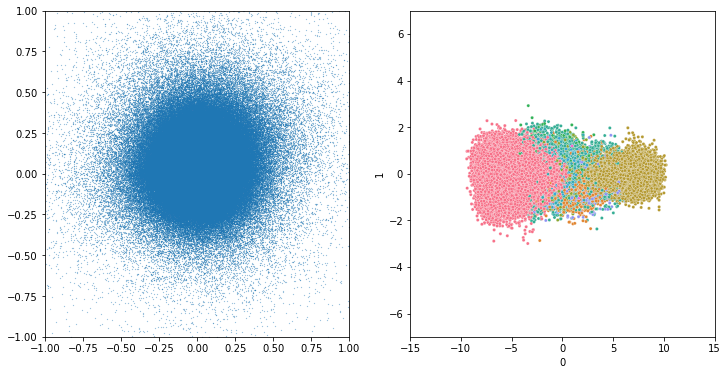

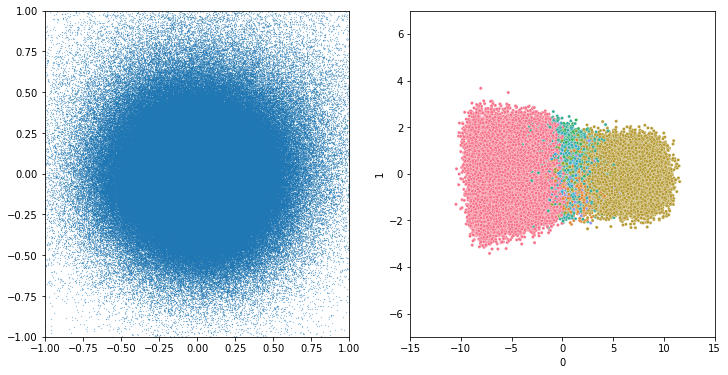

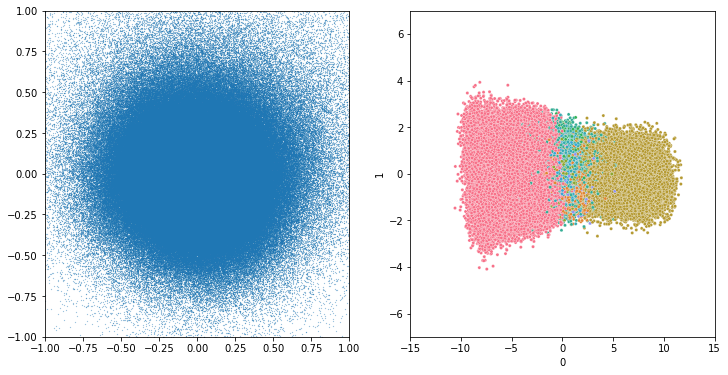

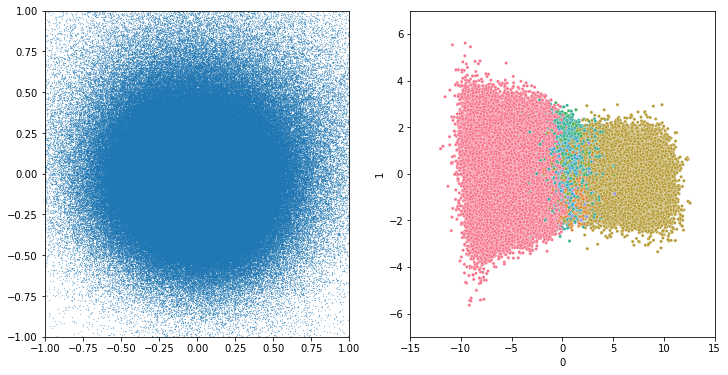

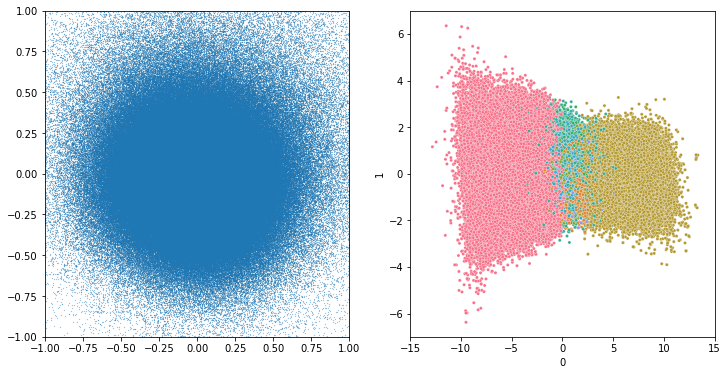

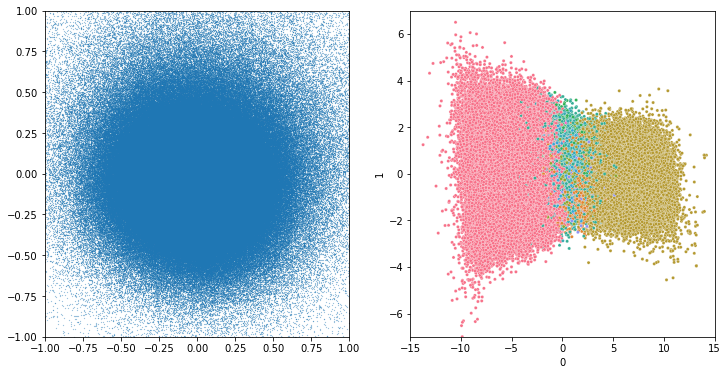

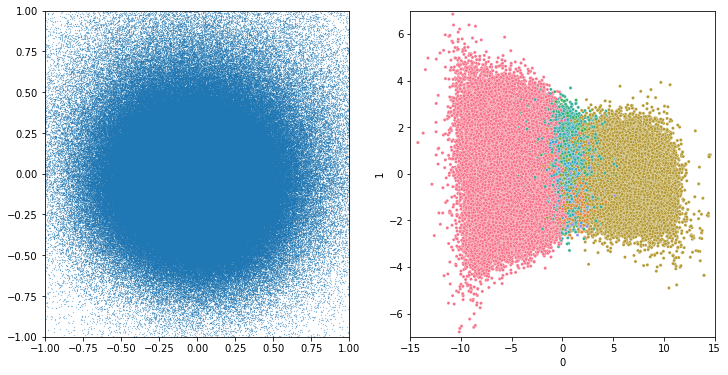

In [31]:
e, c, women_means, men_means, item_pca = analyse(epochs, models, categories, women_ids, men_ids)

<AxesSubplot:xlabel='0', ylabel='1'>

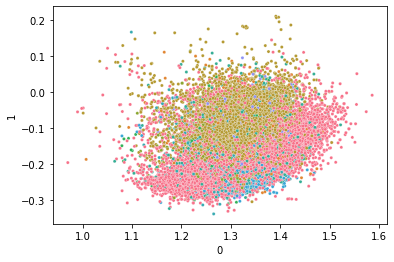

In [13]:
word2vec_embeddings = pd.read_parquet('/pio/scratch/1/recommender_systems/processed/word2vec/amazon-clothes/5-core/item_item_embeddings.parquet')
transformed = pd.DataFrame(item_pca.transform(word2vec_embeddings))
transformed.index = word2vec_embeddings.index
transformed = transformed.join(categories.set_index('asin'))
transformed.columns = ['0', '1', 'category_1', 'category_2']
sns.scatterplot(x='0', y='1', data=transformed, hue='category_1', s=10, legend=False)

<AxesSubplot:xlabel='0', ylabel='1'>

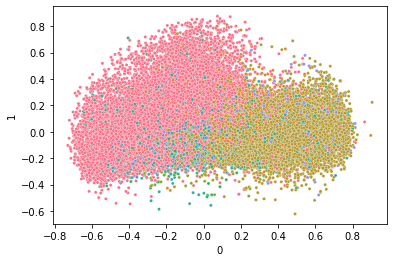

In [14]:
t2 = pd.DataFrame(PCA(n_components=2).fit_transform(word2vec_embeddings))
t2.index = word2vec_embeddings.index
t2 = t2.join(categories.set_index('asin'))
t2.columns = ['0', '1', 'category_1', 'category_2']
sns.scatterplot(x='0', y='1', data=t2, hue='category_1', s=10, legend=False)

Eucl dist


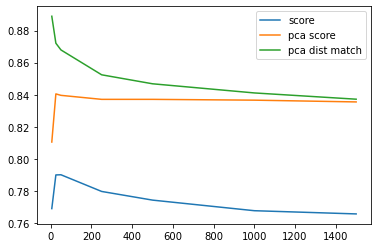

Cos dist


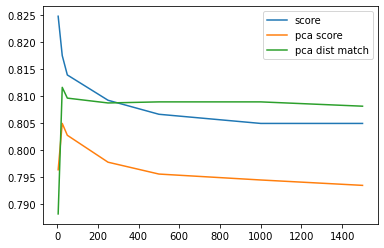

In [15]:
print("Eucl dist")
plt.plot(np.tile(epochs, (3, 1)).T, e)
plt.legend(["score", "pca score", "pca dist match"])
plt.show()
print("Cos dist")
plt.plot(np.tile(epochs, (3, 1)).T, c)
plt.legend(["score", "pca score", "pca dist match"])
plt.show()

In [16]:
e

[[0.769, 0.8105, 0.8889],
 [0.79, 0.8405, 0.8721],
 [0.7901, 0.8396, 0.8679],
 [0.7797, 0.8371, 0.8524],
 [0.7743, 0.8371, 0.8468],
 [0.7677, 0.8366, 0.8411],
 [0.7657, 0.8355, 0.8372]]

In [17]:
c

[[0.8248, 0.7963, 0.7881],
 [0.8175, 0.8049, 0.8116],
 [0.8139, 0.8027, 0.8096],
 [0.8092, 0.7977, 0.8087],
 [0.8066, 0.7955, 0.8089],
 [0.8049, 0.7944, 0.8089],
 [0.8049, 0.7934, 0.8081]]

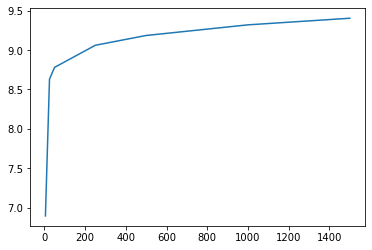

In [18]:
plt.plot(epochs, np.sqrt(((np.array(men_means) - np.array(women_means))**2).sum(axis=1)))

In [19]:
reduced_men_means = item_pca.transform(men_means)
reduced_women_means = item_pca.transform(women_means)

In [20]:
reduced_men_means

array([[ 4.74577776e+00, -3.31217628e-03],
       [ 5.63459360e+00, -3.86364471e-02],
       [ 5.70376737e+00, -4.88020458e-02],
       [ 5.82288027e+00, -7.52594646e-02],
       [ 5.87507526e+00, -8.67897860e-02],
       [ 5.93316264e+00, -9.96524007e-02],
       [ 5.96988913e+00, -1.07600238e-01]])

In [21]:
reduced_women_means

array([[-2.14821881, -0.0725054 ],
       [-2.99184491, -0.06832845],
       [-3.07267695, -0.06421513],
       [-3.23243967, -0.05416409],
       [-3.30378432, -0.04830292],
       [-3.37915205, -0.0414277 ],
       [-3.42520786, -0.03702714]])

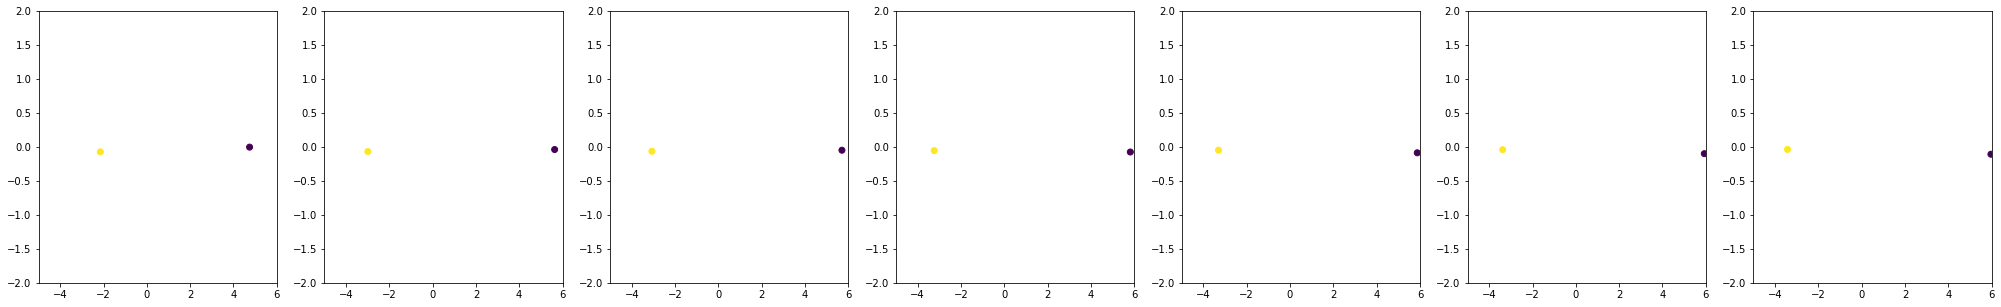

In [27]:
figure, axis = plt.subplots(1, len(epochs), figsize=(len(epochs)*5,5))
for i in range(len(epochs)):
    axis[i].scatter([reduced_men_means[i][0], reduced_women_means[i][0]], [reduced_men_means[i][1], reduced_women_means[i][1]], c=[1, 2])
    axis[i].set_xlim([-5, 6])
    axis[i].set_ylim([-2, 2])

In [23]:
tqdm.pandas()
test_hit_rate_scores, test_recall_scores, test_precision_scores = analyse_metrics(models, train_interactions, test_interactions, dataset)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
test_recall_scores

[0.1663,
 0.21204,
 0.22644,
 0.24494000000000002,
 0.24842000000000009,
 0.25064000000000003,
 0.25178]

In [25]:
test_precision_scores

[0.016630000000000002,
 0.021204,
 0.022644,
 0.024494,
 0.024842000000000003,
 0.025064000000000003,
 0.025178000000000002]

In [26]:
test_hit_rate_scores

[0.3088, 0.3843, 0.4134, 0.4574, 0.4653, 0.4732, 0.4778]